# Twitter Languagemodel Creator

In [6]:
from fastai.fastai.text import *

import csv
import warnings
warnings.filterwarnings('ignore')

In [7]:
PATH = Path("sentiment140/")

CLAS_PATH = Path("twit_clas_50k/")
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH = Path("twit_lm_50k/")
LM_PATH.mkdir(exist_ok=True)

In [8]:
col_names = ["labels", "text"]

In [9]:
def get_texts(path):
    texts, labels, data = [],[],[]
    
    with open(path, "r") as dataset:
        reader = csv.reader(dataset, delimiter=",")
        data = list(reader)
    dataset.close()
    for turn in data:
        texts.append(turn[5])
        labels.append(turn[0])
    return np.array(texts), np.array(labels)



In [10]:
trn_texts, trn_labels = get_texts(PATH/"train.csv")
print(len(trn_texts))

ratio = 10


val_texts, val_labels = trn_texts[:int(len(trn_texts)/ratio)], trn_labels[:int(len(trn_labels)/ratio)]
trn_texts, trn_labels = trn_texts[int(len(trn_texts)/ratio):], trn_labels[int(len(trn_labels)/ratio):]

1600000


In [11]:
len(trn_texts), len(val_texts)

(1440000, 160000)

In [12]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

trn_txts = trn_texts[trn_idx]#[int(len(trn_texts)/2.5):] reduce the size
val_txts = val_texts[val_idx]#[int(len(val_texts)/2.5):]

trn_lbls = trn_labels[trn_idx]#[int(len(trn_labels)/2.5):]
val_lbls = val_labels[val_idx]#[int(len(val_labels)/2.5):]

In [13]:
len(trn_txts), len(val_txts)

(1440000, 160000)

In [14]:
df_trn = pd.DataFrame({"text":trn_txts, "labels":[0]*len(trn_txts)}, columns=col_names)
df_val = pd.DataFrame({"text":val_txts, "labels":[0]*len(val_txts)}, columns=col_names)

In [15]:
df_trn.to_csv(LM_PATH/"train.csv", header=False, index=False)
df_val.to_csv(LM_PATH/"valid.csv", header=False, index=False)

In [16]:
df_trn.head()

,labels,text
0,0,@nzdeany I've given up on pizza - kids would n...
1,0,â†’_â†’ Mum works http://bit.ly/zzb8F )
2,0,Here's one for ya: why would unfollowing peopl...
3,0,aww Andrew got his circ. done today and got hi...
4,0,@lisarinna - you are allowed to quit - just ha...


## Tokenization

In [ ]:
chunksize = 50000
                 
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += df[i].astype(str)
    texts = list(texts)
    
    for i, tweet in enumerate(texts):
        texts[i] = " ".join([word for word in tweet.split() if not ("www." in word) and not ("http" in word) and not ("@" in word)])
    
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [ ]:
def get_all(df, n_lbls=1):
    tok, labels = [],[]
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

In [27]:
df_trn = pd.read_csv(LM_PATH/"train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/"valid.csv", header=None, chunksize=chunksize)

In [28]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3


In [29]:
(LM_PATH/"tmp").mkdir(exist_ok=True)

In [30]:
np.save(LM_PATH/"tmp"/"tok_trn.npy",tok_trn)
np.save(LM_PATH/"tmp"/"tok_val.npy",tok_val)

In [31]:
tok_trn = np.load(LM_PATH/"tmp"/"tok_trn.npy")
tok_val = np.load(LM_PATH/"tmp"/"tok_val.npy")

In [32]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('i', 886293),
 ('.', 764103),
 ('!', 734647),
 ('to', 500423),
 ('the', 470571),
 (',', 432022),
 ('a', 354775),
 ('t_up', 295250),
 ('you', 281082),
 ('my', 279157),
 ('it', 272026),
 ('and', 271766),
 ('is', 218633),
 ('for', 196164),
 ('?', 193900),
 ('...', 193153),
 ('in', 192490),
 ('of', 164588),
 ("'s", 161362),
 ('that', 157746),
 ('on', 150917),
 ("n't", 149034),
 ('me', 144892),
 ('tk_rep', 143326),
 ('have', 137960)]

In [33]:
len(freq),len([value for value in freq.values() if value > 6])

(321439, 41811)

In [34]:
max_vocab = 50000
min_freq = 6

In [35]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, "_unk_")
itos.insert(1, "_pad_")

In [36]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

41813

In [37]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

np.save(LM_PATH/"tmp"/"trn_ids_50k.npy", trn_lm)
np.save(LM_PATH/"tmp"/"val_ids_50k.npy", val_lm)

pickle.dump(itos, open(LM_PATH/"tmp"/"itos_50k.pkl","wb"))

## Language Model

In [ ]:
trn_lm = np.load(LM_PATH/"tmp"/"trn_ids_50k.npy")
val_lm = np.load(LM_PATH/"tmp"/"val_ids_50k.npy")
itos = pickle.load(open(LM_PATH/"tmp"/"itos_50k.pkl","rb"))

vs = len(itos)
vs, len(trn_lm)

In [ ]:
em_sz, nh, nl = 400,1150,3

bptt=70
bs=60 #biggest batch size possible for quicker learning - Figure 6 https://arxiv.org/pdf/1803.09820.pdf
wd=1e-6 #https://arxiv.org/pdf/1803.09820.pdf - smaller wd for large learning rates for super convergence Figure 5 b)
# Smaller datasets and architectures seem to require larger values for weight decay while larger datasets and
# deeper architectures seem to require smaller values. Our hypothesis is that complex data provides
# its own regularization and other regularization should be reduced.
#opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
opt_fn = partial(optim.SGD, momentum=0.9)

In [23]:
t = np.concatenate(trn_lm)
len(t)

22498795

In [ ]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [ ]:
md.trn_dl.data = md.trn_dl.data.long()
md.val_dl.data = md.val_dl.data.long()

In [ ]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15], dtype="f")*0.1

In [ ]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
                      dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip= 0.12
learner.unfreeze()
learner.get_layer_groups()

  9%|██████▎                                                             | 500/5355 [02:30<23:26,  3.45it/s, loss=7.18]

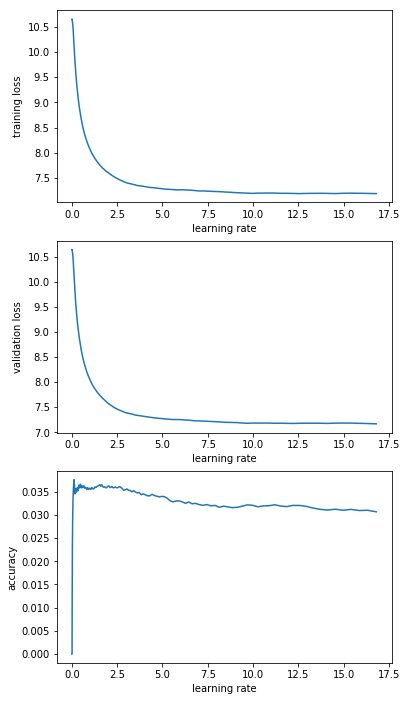

In [14]:
learner.lr_find2(num_it=500, end_lr=20)
learner.sched.plot()

In [27]:
lr = 10

In [28]:
learner.fit(lr, 1,use_clr_beta=(10,10,0.95,0.85), cycle_len=10, best_save_name="best_lm")

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.912822   4.852459   0.200807  
    1      4.680366   4.638419   0.218468                                                                              
    2      4.594694   4.562883   0.224823                                                                              
    3      4.514833   4.54139    0.227381                                                                              
    4      4.519998   4.527254   0.227716                                                                              
    5      4.450755   4.506844   0.230036                                                                              
    6      4.376285   4.495545   0.232021                                                                              
    7      4.330055   4.478956   0.233783                                                                           

[4.454295602552653, 0.23932402076573395]

(None, None)

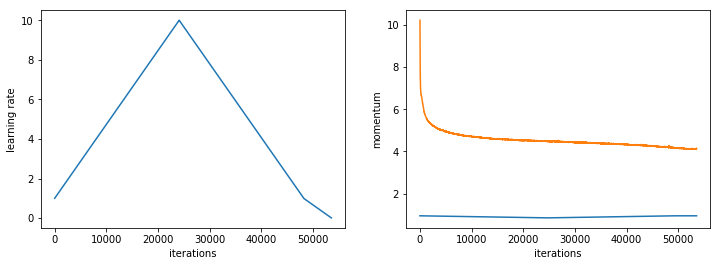

In [29]:
learner.sched.plot_lr(), learner.sched.plot_loss()

In [30]:
learner.save("lm0_fit_50k_bs70_clrB_noQRNN")
learner.save_cycle("lm0_fit_50k_bs70_clrB_noQRNN_cyc", 9)
learner.save_encoder("lm0_fit_50k_bs70_clrB_noQRNN_enc")


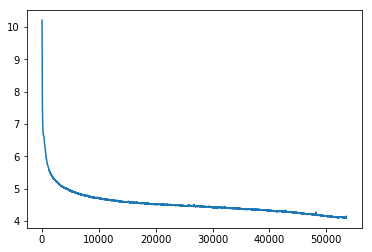

In [31]:
learner.sched.plot_loss()

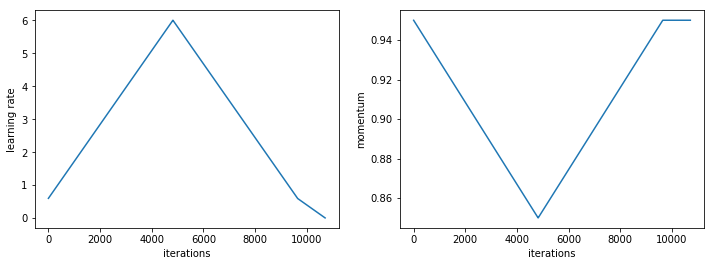

In [19]:
learner.sched.plot_lr()

In [32]:
np.exp(4.15)

63.434000298123344

In [39]:
learner.load("lm0_fit_50k_bs70_clrB_noQRNN")
learner.load_cycle("lm0_fit_50k_bs70_clrB_noQRNN_cyc", 9)
learner.load_encoder("lm0_fit_50k_bs70_clrB_noQRNN_enc")


  9%|██████▎                                                             | 500/5355 [02:32<26:58,  3.00it/s, loss=4.19]

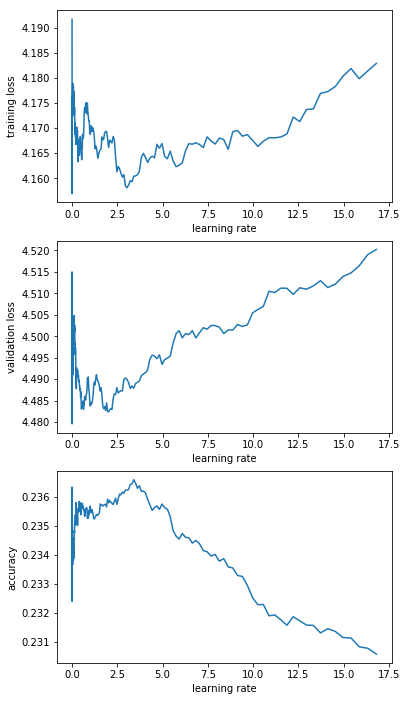

In [40]:
learner.lr_find2(num_it=500, end_lr=20)
learner.sched.plot()

In [41]:
learner.fit(2.5, 1,use_clr_beta=(10,10,0.95,0.85), cycle_len=5, best_save_name="best_lm")

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.130517   4.472025   0.236824  
    1      4.187643   4.46921    0.236924                                                                              
    2      4.124135   4.486281   0.235603                                                                              
    3      4.056145   4.501246   0.235116                                                                              
    4      4.017041   4.496525   0.236268                                                                              


[4.496524851240498, 0.23626774505728804]

In [14]:
math.exp(4.01)

55.1468705634638

## Evaluate 

In [33]:
#from https://github.com/cedrickchee/data-science-notebooks/blob/master/notebooks/deep_learning/ULMFiT/malay_language_model.ipynb

In [42]:
m = learner.model # initialized model
m.eval() # ensure you switch your model to inference mode
m[0].bs = 1 # set batch size to 1

In [15]:
# Load the index-word mapping from the picked file on disk to help us convert the indexes to words.
itos = pickle.load(open(LM_PATH / "tmp" / "itos_50k.pkl", "rb"))

# String to index lambda function
stoi = collections.defaultdict(lambda: 0, {v:k for k, v in enumerate(itos)})
len(itos)

41813

In [44]:
# Utility functions
from random import randint

def gen_text(ss, topk):
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1, 1).cuda()
    t = Variable(t, volatile=False)
    m.reset()
    pred, *_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]

    return [itos[o] for o in to_np(pred_i)]

def generate_sentences(ss, nb_words):
    result = []
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1, 1).cuda()
    t = Variable(t, volatile=False)
    m.reset()
    pred, *_ = m(t)
    
    #for i in range(nb_words):
    word = ""
    while (word != "." and word !="..."):
        pred_i = pred[-1].topk(3)[1]
        idx = randint(1,len(pred_i)-1)
        pred_i = pred_i[idx] #if pred_i.data[0] < 1 else pred_i[1]
        if pred_i.data[0] != 0:
            word = itos[pred_i.data[0]]
            result.append(word)
            pred, *_ = m((pred_i[0].unsqueeze(0).expand(1,2)))
    
    result = re.sub('\s+([.,])', r'\1', "{} {}".format(ss, " ".join(result).rstrip()))

    return(result)

In [45]:
strings = [
    "Shit",
    "I am broke",
    "For god",
    "a clown",
    "My sister",
    "Hio",
    "My dear"
]

In [46]:
for s in strings:
    print(f"{s}... \n{generate_sentences(s.lower(), 25)}\n")

Shit... 
shit, but it is not possible.

I am broke... 
i am broke and we 'll see if we get a chance.

For god... 
for god 's name is on it ! it was n't a problem.

a clown... 
a clown ! i am lost ! i have n't seen the movie in a l...

My sister... 
my sister and we 'll see how that turns off ! i am lost ! pls pls please please ? ? i 'm sorry to tell anyone who 's still not there...

Hio... 
hio i m gon miss the t_up bgt awards i have to get my wisdom braces removed in a month ! and it hurts so much.

My dear... 
my dear friend just got back to my hotel ! had to get my dad a father - day birthday cake ! he was the first one in the history ! i am t_up sooo happy that you had an amazing night, but it was a long night i m going back 2 bed.

